In [127]:
from matplotlib import pyplot as plt

In [128]:
# sys.path.insert(1, '/Users/stephenren/code/fontGAN/src')

from __future__ import print_function, division
import sys
import os
import torch
import numpy as np
import random
import csv
import cv2

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import Sampler

"""
Dataset for loading in alphanumeric (abc..789) character images of given fonts
"""
class FontDataset(Dataset):
    """
    @ params
    fonts_directory (str): High level directory which contains subdirectories of fonts
        The subdirectories are named by their font name (e.g. Helvetica-Regular)
        Each directory contains images of lower and uppercase characters and numerals 0-9
        Images of 
    num_condition (int, tuple<int>): The number of characters to stack together as a condition
        If tuple, gives a low-high range for number of characters given
    """
    def __init__(self, fonts_directory, num_condition=7, dims=(256,256), max_img_dim=64, n_chars=128, regular_only=False, src_corpus=None, tgt_corpus=None):
        self.fonts_directory = fonts_directory
        self.num_condition = num_condition
        self.dims = dims
        self.max_img_dim=128
        self.n_chars = n_chars
        self.regular_only = regular_only
        self.src_corpus = src_corpus if src_corpus is not None else [['H', 'e-1', 'l-1', 'l-1', 'o-1']]
        self.tgt_corpus = tgt_corpus if tgt_corpus is not None else [['T', 'h-1', 'e-1', 'r-1', 'e-1']]

        self.fonts = []
        for font_name in os.listdir(self.fonts_directory):
            if regular_only and font_name.split('-')[-1] != 'Regular':
                continue
            self.fonts.append(font_name)

    def _load_char_images(self, idx):
        fontName = self.fonts[idx]
        char_dir = os.path.join(self.fonts_directory, fontName)

        out = {}
        for filename in os.listdir(char_dir):
            if filename[0] == '.':
                continue
            max_h, max_w = self.max_img_dim, self.max_img_dim
            image = cv2.imread(os.path.join(char_dir, filename), cv2.IMREAD_GRAYSCALE).astype(np.float) / 255
            h, w = image.shape
            image = image[:min(self.max_img_dim, h), :min(self.max_img_dim, w)]
            h, w = image.shape
            pad_h, pad_w = self.max_img_dim, self.max_img_dim
            
            padded_image = np.ones((self.max_img_dim, self.max_img_dim)).astype(np.float)
            h_start, w_start = (pad_h - h) // 2, (pad_w - w) // 2
            padded_image[h_start:h_start + h, w_start: w_start + w] = image

            # Key = 'a', 'b', 'Z', '0', etc
            out[str(filename.split('.')[0])] = padded_image
        
        return out
    
    def _shape_image(self, image, cfg=None):
        out_h, out_w = self.dims
        if cfg is None:
            h, w = image.shape
            span = np.random.uniform(0.5, 1)
            scale = out_w * span / w
            new_h, new_w = int(h * scale), int(w * scale)
            start_h, start_w = np.random.randint(0, out_h - new_h), np.random.randint(out_w - new_w)
            cfg = start_h, start_w, scale
        
        h, w = image.shape
        start_h, start_w, scale = cfg
        new_h, new_w = int(h * scale), int(w * scale)
        out = np.ones((out_h, out_w)).astype(np.float)
        img = cv2.resize(image, (new_w, new_h))
        out[start_h: start_h + new_h, start_w: start_w + new_w] = img
        return out, cfg
        
        if w <= self.dims[1]:
            w_start = (self.dims[1] - w) // 2
            out[:, w_start:w_start + w] = image
        else:
            new_h = int(h * self.dims[1] / w)
            img = cv2.resize(image, (self.dims[1], new_h))
            h_start = (self.dims[0] - new_h) // 2
            out[h_start: h_start + new_h, :] = img
        
        return out

    """
    Returns an font item of a certain font type (e.g. Helvetica-Reular)
    In the form of a condition, target tuple:
    condition: (w, h, 62) tensor of n random character images, where most of the 62 is noise
    target: (w, h, 62) tensor of all the alphanumeric character images
    """
    def __getitem__(self, idx):
        char_images = self._load_char_images(idx)
        rnd_char_images = self._load_char_images(np.random.randint(self.__len__()))
        
        word = ['H', 'e-1', 'l-1', 'l-1', 'o-1']
        target_word = ['T', 'h-1', 'e-1', 'r-1', 'e-1']
        orig_font, cfg = self._shape_image(np.concatenate([char_images[key] for key in word], axis=1))
        condition, _ = self._shape_image(np.concatenate([rnd_char_images[key] for key in target_word], axis=1))
        target, _ = self._shape_image(np.concatenate([char_images[key] for key in target_word], axis=1), cfg)
        
        return 1 - orig_font, 1 - condition, 1 - target
        
#         # Sort the images by keys, turn into array
#         char_images = 1 - np.array([char_images[key] for key in sorted(list(char_images.keys()))]).astype(np.float) / 255

#         target = char_images
#         condition = np.zeros((self.n_chars, self.dims[0], self.dims[1])).astype(np.float)
#         # random indices of 
#         condition_idxs = np.random.choice(self.n_chars, self.num_condition)
#         condition[condition_idxs] = target[condition_idxs]
        
#         condition = condition.transpose(1, 2, 0)
#         target = target.transpose(1, 2, 0)
        
#         condition = torch.from_numpy(condition)
#         target = torch.from_numpy(target)
        
#         return condition, target, condition_idxs

    def __len__(self):
        return len(self.fonts)        


In [129]:
dataset = FontDataset(fonts_directory='/Users/stephenren/code/fontData/font_characters_splits/train', num_condition=10)

In [132]:
orig_font, condition, target = dataset[44]

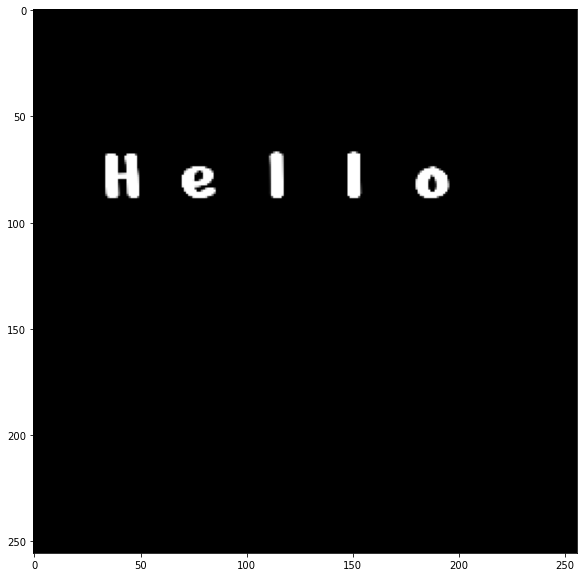

In [133]:
plt.gcf().set_size_inches(15,10)
plt.imshow(orig_font, cmap='gray')